In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

##### Importing Relevant Packages

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold
import re

In [3]:
# load datasets
train = pd.read_csv("Train.csv")
test  = pd.read_csv("Test.csv")
sample  = pd.read_csv("sample_submission.csv")
var = pd.read_csv('VariableDefinitions.csv')

In [4]:
var.head(3)

,Variable Definitions,Unnamed: 1,Unnamed: 2
0,NaN,French,English
1,NaN,Le dataset churn comprend 19 variables dont 15...,The churn dataset includes 19 variables includ...
2,user_id,NaN,NaN


In [5]:
train.head(2)
train.shape

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0


(400000, 19)

##### Feature Engineering

In [6]:
useless = ['user_id', 'MRG']

In [7]:
train.REGION.fillna('REG',inplace=True)
test.REGION.fillna('REG',inplace=True)

In [8]:
train.TOP_PACK.fillna('PACK',inplace=True)
test.TOP_PACK.fillna('PACK',inplace=True)

In [9]:
minus_999999 = ['MONTANT','FREQUENCE_RECH','REVENUE','ARPU_SEGMENT','FREQUENCE','DATA_VOLUME','ON_NET','ORANGE','FREQ_TOP_PACK','TIGO','ZONE1','ZONE2']

In [10]:
for col in minus_999999:
    train[col].fillna(-99999, inplace=True)
    test[col].fillna(-99999, inplace=True)

In [11]:
train.drop(columns=[i for i in useless], inplace=True)
test.drop(columns=[i for i in useless], inplace=True)

In [12]:
data = pd.concat([train,test],axis=0)
data = data.reset_index(drop=True)

In [13]:
categ = ['TENURE','REGION','TOP_PACK'] 

In [14]:
pack_dum = pd.get_dummies(data['TOP_PACK'])

In [15]:
ten_dum = pd.get_dummies(data['TENURE'])

In [16]:
pack_reg = pd.get_dummies(data['REGION'])

In [17]:
data = pd.concat([data,ten_dum,pack_reg,pack_dum],axis=1)

In [18]:
data.drop(columns=[i for i in categ], inplace=True)

In [19]:
data.head(3)

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,VAS(IVR_Radio_Monthly),VAS(IVR_Radio_Weekly),WIFI_ Family _10MBPS,WIFI_ Family _4MBPS,WIFI_Family_2MBPS,"YMGX 100=1 hour FNF, 24H/1 month",Yewouleen_PKG,pack_chinguitel_24h,pilot_offer5,pilot_offer6
0,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,6.0,-99999.0,...,0,0,0,0,0,0,0,0,0,0
1,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,-99999.0,...,0,0,0,0,0,0,0,0,0,0
2,1500.0,3.0,1500.0,500.0,3.0,-99999.0,30.0,30.0,-99999.0,-99999.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
train=data[data.CHURN.notnull()].reset_index(drop=True)
test=data[data.CHURN.isna()].reset_index(drop=True)

In [21]:
y = train.CHURN
train.drop('CHURN', axis=1, inplace=True)
test.drop('CHURN', axis=1, inplace=True)

In [22]:
test.head(2)
train.shape

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,VAS(IVR_Radio_Monthly),VAS(IVR_Radio_Weekly),WIFI_ Family _10MBPS,WIFI_ Family _4MBPS,WIFI_Family_2MBPS,"YMGX 100=1 hour FNF, 24H/1 month",Yewouleen_PKG,pack_chinguitel_24h,pilot_offer5,pilot_offer6
0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,...,0,0,0,0,0,0,0,0,0,0
1,-99999.0,-99999.0,10.0,3.0,1.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,...,0,0,0,0,0,0,0,0,0,0


(400000, 149)

In [23]:
c = [i for i in train.columns if train[i].dtype == object]

In [24]:
len(c)

0

In [25]:
train.shape, y.shape, test.shape

((400000, 149), (400000,), (100000, 149))

In [26]:
clust = [
'REVENUE',
'MONTANT',
'FREQUENCE_RECH',
'ARPU_SEGMENT',
'FREQUENCE',
'ON_NET',
'ORANGE',
'REGULARITY',
'FREQ_TOP_PACK',
'REG',
'PACK']

##### NOTE
I already did feature selection and correlation to determine what features mattered in predicting customer churn for this dataset. So this clust variable above is not something I randomly chose

In [27]:
# for j in clust:
#     distortions = []
#     if train[j].dtype == object:
#         dummies = pd.get_dummies(train[j], drop_first=True)
#         for i in range(1, 11):
#             km = KMeans(
#                 n_clusters=i, init='k-means++',
#                 n_init=20, max_iter=300,
#                 tol=1e-04, random_state=0
#             )
#             km.fit(dummies)
#             distortions.append(km.inertia_)

#         # plot
#         print(j, km.inertia_)
#         plt.plot(range(1, 11), distortions, marker='o')
#         plt.xlabel('Number of clusters')
#         plt.ylabel('Distortion')
#         plt.show()
    
#     else:
#         for i in range(1, 11):
#             km = KMeans(
#                 n_clusters=i, init='k-means++',
#                 n_init=20, max_iter=300,
#                 tol=1e-04, random_state=0
#             )
#             km.fit(pd.DataFrame(train[j]))
#             distortions.append(km.inertia_)

#         # plot

#         print(j, km.inertia_)
#         plt.plot(range(1, 11), distortions, marker='o')
#         plt.xlabel('Number of clusters')
#         plt.ylabel('Distortion')
#         plt.show()

The above cell is quite computationally expensive and should only be run if you're interested in seeing the plots I used in determining the optimal k values, using the elbow method, also most k values i got were 2.

In [28]:
kmeans = KMeans(
        n_clusters=2, init='k-means++',
        n_init=20, max_iter=300,
        tol=1e-04, random_state=0
    )

In [29]:
for col in clust:
    if train[col].dtype == object:
        dummies = pd.get_dummies(train[col], drop_first=True)
        test_dum = pd.get_dummies(test[col], drop_first=True)
        kmeans.fit(dummies)
        train[col+'_grouped'] = kmeans.labels_
        test[col+'_grouped'] = kmeans.predict(test_dum)
    else:
        kmeans.fit(pd.DataFrame(train[col]))
        train[col+'_grouped'] = kmeans.labels_
        test[col+'_grouped'] = kmeans.predict(pd.DataFrame(test[col]))

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

In [30]:
train.head(3)

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,MONTANT_grouped,FREQUENCE_RECH_grouped,ARPU_SEGMENT_grouped,FREQUENCE_grouped,ON_NET_grouped,ORANGE_grouped,REGULARITY_grouped,FREQ_TOP_PACK_grouped,REG_grouped,PACK_grouped
0,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,6.0,-99999.0,...,1,1,1,0,0,0,1,0,1,1
1,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,-99999.0,...,1,1,1,0,0,0,1,0,0,1
2,1500.0,3.0,1500.0,500.0,3.0,-99999.0,30.0,30.0,-99999.0,-99999.0,...,1,1,1,0,0,0,1,0,1,1


In [31]:
train.shape, test.shape

((400000, 160), (100000, 160))

In [32]:
train['sep'] = 1
test['sep'] = np.nan

In [33]:
data = pd.concat([train,test],axis=0)
data = data.reset_index(drop=True)

In [34]:
grouped = train.columns.to_list()[-12:]

In [35]:
grouped.remove('sep')

In [36]:
grouped

['REVENUE_grouped',
 'MONTANT_grouped',
 'FREQUENCE_RECH_grouped',
 'ARPU_SEGMENT_grouped',
 'FREQUENCE_grouped',
 'ON_NET_grouped',
 'ORANGE_grouped',
 'REGULARITY_grouped',
 'FREQ_TOP_PACK_grouped',
 'REG_grouped',
 'PACK_grouped']

In [37]:
REVENUE_grouped = pd.get_dummies(data.REVENUE_grouped, prefix = 'rev')

MONTANT_grouped = pd.get_dummies(data.MONTANT_grouped, prefix = 'mon')

FREQUENCE_RECH_grouped = pd.get_dummies(data.FREQUENCE_RECH_grouped, prefix = 'FR')

ON_NET_grouped = pd.get_dummies(data.ON_NET_grouped, prefix = 'ON_N')

ARPU_SEGMENT_grouped = pd.get_dummies(data.ARPU_SEGMENT_grouped, prefix = 'ARp')

FREQUENCE_grouped = pd.get_dummies(data.FREQUENCE_grouped, prefix = 'FREQUE')

ORANGE_grouped = pd.get_dummies(data.ORANGE_grouped, prefix = 'ORN')

REGULARITY_grouped = pd.get_dummies(data.REGULARITY_grouped, prefix = 'REGU')

FREQ_TOP_PACK_grouped = pd.get_dummies(data.FREQ_TOP_PACK_grouped, prefix = 'FREQTP')

REG_grouped = pd.get_dummies(data.REG_grouped, prefix = 'R')

PACK_grouped = pd.get_dummies(data.PACK_grouped, prefix = 'PK')

In [38]:
# I later realized I could have also done data = pd.get_dummies(data, prefix = grouped, columns = grouped), but I still like it this way.

In [39]:
data = pd.concat([data,REG_grouped,REGULARITY_grouped,REVENUE_grouped, MONTANT_grouped,FREQ_TOP_PACK_grouped, FREQUENCE_grouped, FREQUENCE_RECH_grouped, ON_NET_grouped,ARPU_SEGMENT_grouped, ORANGE_grouped,PACK_grouped ],axis=1) #

In [40]:
data.head(3)

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,FR_0,FR_1,ON_N_0,ON_N_1,ARp_0,ARp_1,ORN_0,ORN_1,PK_0,PK_1
0,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,6.0,-99999.0,...,0,1,1,0,0,1,1,0,0,1
1,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,-99999.0,...,0,1,1,0,0,1,1,0,0,1
2,1500.0,3.0,1500.0,500.0,3.0,-99999.0,30.0,30.0,-99999.0,-99999.0,...,0,1,1,0,0,1,1,0,0,1


In [41]:
train=data[data.sep.notnull()].reset_index(drop=True)
test=data[data.sep.isna()].reset_index(drop=True)

In [42]:
train.drop(columns=['sep'], inplace=True)
test.drop(columns=['sep'], inplace=True)

KMeans(n_clusters=1, n_init=20, random_state=0)

KMeans(n_clusters=2, n_init=20, random_state=0)

KMeans(n_clusters=3, n_init=20, random_state=0)

KMeans(n_clusters=4, n_init=20, random_state=0)

KMeans(n_clusters=5, n_init=20, random_state=0)

KMeans(n_clusters=6, n_init=20, random_state=0)

KMeans(n_clusters=7, n_init=20, random_state=0)

KMeans(n_init=20, random_state=0)

KMeans(n_clusters=9, n_init=20, random_state=0)

KMeans(n_clusters=10, n_init=20, random_state=0)

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'Distortion')

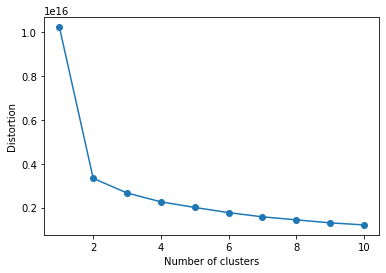

In [44]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=20, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(pd.DataFrame(train))
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

The above cell is quite computationally expensive and should only be run if you're interested in seeing the plots I used in determining the optimal k values, using the elbow method, also most k values i got were 2.

In [44]:
km = KMeans(
        n_clusters=3, init='k-means++',
        n_init=20, max_iter=300,
        tol=1e-04, random_state=0
    )

In [45]:
km.fit(train)

KMeans(n_clusters=3, n_init=20, random_state=0)

In [46]:
train['groups'] = km.labels_
test['groups'] = km.predict(test)

In [47]:
train.shape, y.shape, test.shape

((400000, 183), (400000,), (100000, 183))

In [48]:
train.head(3)

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,FR_1,ON_N_0,ON_N_1,ARp_0,ARp_1,ORN_0,ORN_1,PK_0,PK_1,groups
0,17000.0,32.0,18000.0,6000.0,34.0,-99999.0,97.0,355.0,6.0,-99999.0,...,1,1,0,0,1,1,0,0,1,2
1,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,-99999.0,...,1,1,0,0,1,1,0,0,1,2
2,1500.0,3.0,1500.0,500.0,3.0,-99999.0,30.0,30.0,-99999.0,-99999.0,...,1,1,0,0,1,1,0,0,1,1


##### Local Validation

In [45]:
X_1, X_2, y_1, y_2 = train_test_split(train, y, test_size = 0.01, random_state = 0)

In [46]:
X_3, X_4, y_3, y_4 = train_test_split(X_2, y_2, test_size = 0.1, random_state = 2001)

In [47]:
X_3.shape, y_3.shape

((3600, 182), (3600,))

In [52]:
val_model = CatBoostClassifier(random_seed=0, n_estimators=1200)

In [53]:
val_model.fit(X_3, y_3)

Learning rate set to 0.015061
0:	learn: 0.6671695	total: 368ms	remaining: 7m 21s
1:	learn: 0.6461074	total: 383ms	remaining: 3m 49s
2:	learn: 0.6234335	total: 407ms	remaining: 2m 42s
3:	learn: 0.6017402	total: 431ms	remaining: 2m 8s
4:	learn: 0.5816300	total: 454ms	remaining: 1m 48s
5:	learn: 0.5626531	total: 476ms	remaining: 1m 34s
6:	learn: 0.5469134	total: 498ms	remaining: 1m 24s
7:	learn: 0.5299518	total: 528ms	remaining: 1m 18s
8:	learn: 0.5150593	total: 550ms	remaining: 1m 12s
9:	learn: 0.4997163	total: 584ms	remaining: 1m 9s
10:	learn: 0.4861292	total: 609ms	remaining: 1m 5s
11:	learn: 0.4735766	total: 639ms	remaining: 1m 3s
12:	learn: 0.4606597	total: 664ms	remaining: 1m
13:	learn: 0.4495739	total: 682ms	remaining: 57.7s
14:	learn: 0.4390291	total: 702ms	remaining: 55.4s
15:	learn: 0.4328558	total: 732ms	remaining: 54.2s
16:	learn: 0.4238303	total: 764ms	remaining: 53.2s
17:	learn: 0.4143783	total: 789ms	remaining: 51.8s
18:	learn: 0.4056761	total: 813ms	remaining: 50.5s
19:	le

168:	learn: 0.2388837	total: 3.72s	remaining: 22.7s
169:	learn: 0.2387382	total: 3.75s	remaining: 22.7s
170:	learn: 0.2386937	total: 3.79s	remaining: 22.8s
171:	learn: 0.2386129	total: 3.81s	remaining: 22.8s
172:	learn: 0.2385031	total: 3.82s	remaining: 22.7s
173:	learn: 0.2383952	total: 3.83s	remaining: 22.6s
174:	learn: 0.2383194	total: 3.84s	remaining: 22.5s
175:	learn: 0.2382050	total: 3.85s	remaining: 22.4s
176:	learn: 0.2381706	total: 3.86s	remaining: 22.3s
177:	learn: 0.2380085	total: 3.88s	remaining: 22.3s
178:	learn: 0.2379405	total: 3.9s	remaining: 22.2s
179:	learn: 0.2379101	total: 3.91s	remaining: 22.2s
180:	learn: 0.2377140	total: 3.94s	remaining: 22.2s
181:	learn: 0.2375523	total: 3.96s	remaining: 22.1s
182:	learn: 0.2374225	total: 3.97s	remaining: 22.1s
183:	learn: 0.2373451	total: 3.98s	remaining: 22s
184:	learn: 0.2372676	total: 3.99s	remaining: 21.9s
185:	learn: 0.2372344	total: 4s	remaining: 21.8s
186:	learn: 0.2371781	total: 4.01s	remaining: 21.8s
187:	learn: 0.2370

338:	learn: 0.2265755	total: 5.48s	remaining: 13.9s
339:	learn: 0.2264443	total: 5.49s	remaining: 13.9s
340:	learn: 0.2263547	total: 5.5s	remaining: 13.8s
341:	learn: 0.2262936	total: 5.5s	remaining: 13.8s
342:	learn: 0.2262543	total: 5.51s	remaining: 13.8s
343:	learn: 0.2261290	total: 5.52s	remaining: 13.7s
344:	learn: 0.2260900	total: 5.52s	remaining: 13.7s
345:	learn: 0.2260625	total: 5.53s	remaining: 13.6s
346:	learn: 0.2260343	total: 5.54s	remaining: 13.6s
347:	learn: 0.2259670	total: 5.54s	remaining: 13.6s
348:	learn: 0.2258681	total: 5.55s	remaining: 13.5s
349:	learn: 0.2258355	total: 5.55s	remaining: 13.5s
350:	learn: 0.2257219	total: 5.56s	remaining: 13.4s
351:	learn: 0.2256955	total: 5.57s	remaining: 13.4s
352:	learn: 0.2255839	total: 5.57s	remaining: 13.4s
353:	learn: 0.2255264	total: 5.58s	remaining: 13.3s
354:	learn: 0.2253351	total: 5.58s	remaining: 13.3s
355:	learn: 0.2252865	total: 5.59s	remaining: 13.3s
356:	learn: 0.2252366	total: 5.6s	remaining: 13.2s
357:	learn: 0.2

506:	learn: 0.2183985	total: 6.54s	remaining: 8.94s
507:	learn: 0.2183762	total: 6.54s	remaining: 8.92s
508:	learn: 0.2183195	total: 6.55s	remaining: 8.9s
509:	learn: 0.2182444	total: 6.56s	remaining: 8.88s
510:	learn: 0.2182234	total: 6.57s	remaining: 8.86s
511:	learn: 0.2182124	total: 6.57s	remaining: 8.83s
512:	learn: 0.2180844	total: 6.58s	remaining: 8.81s
513:	learn: 0.2180145	total: 6.59s	remaining: 8.79s
514:	learn: 0.2179939	total: 6.59s	remaining: 8.77s
515:	learn: 0.2179708	total: 6.6s	remaining: 8.75s
516:	learn: 0.2179416	total: 6.6s	remaining: 8.72s
517:	learn: 0.2178977	total: 6.61s	remaining: 8.7s
518:	learn: 0.2178501	total: 6.62s	remaining: 8.68s
519:	learn: 0.2178097	total: 6.62s	remaining: 8.66s
520:	learn: 0.2177607	total: 6.63s	remaining: 8.64s
521:	learn: 0.2177483	total: 6.63s	remaining: 8.62s
522:	learn: 0.2176927	total: 6.64s	remaining: 8.6s
523:	learn: 0.2176246	total: 6.65s	remaining: 8.57s
524:	learn: 0.2175965	total: 6.65s	remaining: 8.55s
525:	learn: 0.217

667:	learn: 0.2112989	total: 7.6s	remaining: 6.05s
668:	learn: 0.2112929	total: 7.61s	remaining: 6.04s
669:	learn: 0.2112687	total: 7.61s	remaining: 6.02s
670:	learn: 0.2112641	total: 7.62s	remaining: 6.01s
671:	learn: 0.2112289	total: 7.63s	remaining: 5.99s
672:	learn: 0.2111862	total: 7.63s	remaining: 5.98s
673:	learn: 0.2111043	total: 7.64s	remaining: 5.96s
674:	learn: 0.2110901	total: 7.64s	remaining: 5.95s
675:	learn: 0.2110755	total: 7.65s	remaining: 5.93s
676:	learn: 0.2110275	total: 7.66s	remaining: 5.92s
677:	learn: 0.2108914	total: 7.66s	remaining: 5.9s
678:	learn: 0.2108393	total: 7.67s	remaining: 5.88s
679:	learn: 0.2107817	total: 7.67s	remaining: 5.87s
680:	learn: 0.2107662	total: 7.68s	remaining: 5.85s
681:	learn: 0.2106864	total: 7.69s	remaining: 5.84s
682:	learn: 0.2106296	total: 7.69s	remaining: 5.82s
683:	learn: 0.2106245	total: 7.7s	remaining: 5.81s
684:	learn: 0.2106068	total: 7.7s	remaining: 5.79s
685:	learn: 0.2105629	total: 7.71s	remaining: 5.78s
686:	learn: 0.21

847:	learn: 0.2040671	total: 8.82s	remaining: 3.66s
848:	learn: 0.2040622	total: 8.82s	remaining: 3.65s
849:	learn: 0.2040113	total: 8.83s	remaining: 3.64s
850:	learn: 0.2039257	total: 8.84s	remaining: 3.63s
851:	learn: 0.2039041	total: 8.85s	remaining: 3.61s
852:	learn: 0.2038945	total: 8.85s	remaining: 3.6s
853:	learn: 0.2038208	total: 8.86s	remaining: 3.59s
854:	learn: 0.2037795	total: 8.87s	remaining: 3.58s
855:	learn: 0.2037585	total: 8.88s	remaining: 3.57s
856:	learn: 0.2037150	total: 8.88s	remaining: 3.56s
857:	learn: 0.2036906	total: 8.89s	remaining: 3.54s
858:	learn: 0.2036755	total: 8.9s	remaining: 3.53s
859:	learn: 0.2036705	total: 8.9s	remaining: 3.52s
860:	learn: 0.2036452	total: 8.91s	remaining: 3.51s
861:	learn: 0.2036081	total: 8.92s	remaining: 3.5s
862:	learn: 0.2036026	total: 8.92s	remaining: 3.48s
863:	learn: 0.2035312	total: 8.93s	remaining: 3.47s
864:	learn: 0.2035190	total: 8.94s	remaining: 3.46s
865:	learn: 0.2034613	total: 8.94s	remaining: 3.45s
866:	learn: 0.20

1027:	learn: 0.1977109	total: 10s	remaining: 1.68s
1028:	learn: 0.1976970	total: 10s	remaining: 1.67s
1029:	learn: 0.1976606	total: 10.1s	remaining: 1.66s
1030:	learn: 0.1976269	total: 10.1s	remaining: 1.65s
1031:	learn: 0.1976078	total: 10.1s	remaining: 1.64s
1032:	learn: 0.1975668	total: 10.1s	remaining: 1.63s
1033:	learn: 0.1975193	total: 10.1s	remaining: 1.62s
1034:	learn: 0.1975058	total: 10.1s	remaining: 1.61s
1035:	learn: 0.1974685	total: 10.1s	remaining: 1.6s
1036:	learn: 0.1974043	total: 10.1s	remaining: 1.59s
1037:	learn: 0.1973389	total: 10.1s	remaining: 1.58s
1038:	learn: 0.1973138	total: 10.1s	remaining: 1.57s
1039:	learn: 0.1972780	total: 10.1s	remaining: 1.56s
1040:	learn: 0.1972371	total: 10.1s	remaining: 1.55s
1041:	learn: 0.1971963	total: 10.1s	remaining: 1.54s
1042:	learn: 0.1971608	total: 10.1s	remaining: 1.53s
1043:	learn: 0.1971103	total: 10.1s	remaining: 1.52s
1044:	learn: 0.1970578	total: 10.2s	remaining: 1.51s
1045:	learn: 0.1970532	total: 10.2s	remaining: 1.5s

1183:	learn: 0.1929590	total: 11.1s	remaining: 150ms
1184:	learn: 0.1929224	total: 11.1s	remaining: 141ms
1185:	learn: 0.1929013	total: 11.1s	remaining: 131ms
1186:	learn: 0.1928490	total: 11.1s	remaining: 122ms
1187:	learn: 0.1928389	total: 11.1s	remaining: 112ms
1188:	learn: 0.1927857	total: 11.1s	remaining: 103ms
1189:	learn: 0.1927175	total: 11.1s	remaining: 93.6ms
1190:	learn: 0.1927132	total: 11.1s	remaining: 84.2ms
1191:	learn: 0.1927091	total: 11.2s	remaining: 74.9ms
1192:	learn: 0.1926640	total: 11.2s	remaining: 65.5ms
1193:	learn: 0.1926393	total: 11.2s	remaining: 56.1ms
1194:	learn: 0.1926377	total: 11.2s	remaining: 46.8ms
1195:	learn: 0.1926272	total: 11.2s	remaining: 37.4ms
1196:	learn: 0.1926255	total: 11.2s	remaining: 28ms
1197:	learn: 0.1925957	total: 11.2s	remaining: 18.7ms
1198:	learn: 0.1925904	total: 11.2s	remaining: 9.34ms
1199:	learn: 0.1925731	total: 11.2s	remaining: 0us


In [54]:
val_pred = val_model.predict_proba(X_4)[:, 1]

In [55]:
log_loss(y_4, val_pred)

0.25665963751575727

Local CV log_loss score of about 0.255 seems okay, but caution is that it's just a very sample from our dataset.

##### Model Training

Models I used in making my preddictions are catboost and xgboost

Catboost single model

25-KFold Catboost model

In [65]:
train.shape, test.shape, y.shape

((400000, 183), (100000, 183), (400000,))

In [122]:
errcb1=[]
y_pred_totcb2=[]
fold=KFold(n_splits=25)#25
i=1
for train_index, test_index in fold.split(train,y):
    print(str(i) + ' iter')
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostClassifier(n_estimators=1000,eval_metric='Logloss',random_seed= 10, use_best_model=True)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    preds=m2.predict_proba(X_test)[:,1]
    print("err: ",log_loss(y_test,preds))
    errcb1.append((log_loss(y_test,preds)))
    p2 = m2.predict_proba(test)[:,1]
    y_pred_totcb2.append(p2)
    i+=1
np.mean(errcb1)

1 iter
Learning rate set to 0.137797
0:	learn: 0.5180190	test: 0.5180190	test1: 0.5171118	best: 0.5171118 (0)	total: 972ms	remaining: 16m 11s
100:	learn: 0.2511525	test: 0.2511525	test1: 0.2479223	best: 0.2479223 (100)	total: 29.5s	remaining: 4m 22s
200:	learn: 0.2495545	test: 0.2495545	test1: 0.2476114	best: 0.2476013 (170)	total: 45.1s	remaining: 2m 59s
300:	learn: 0.2483376	test: 0.2483376	test1: 0.2476021	best: 0.2475947 (238)	total: 1m 1s	remaining: 2m 22s
400:	learn: 0.2472542	test: 0.2472542	test1: 0.2474925	best: 0.2474742 (393)	total: 1m 18s	remaining: 1m 57s
500:	learn: 0.2464047	test: 0.2464047	test1: 0.2474760	best: 0.2473522 (447)	total: 1m 35s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2473522276
bestIteration = 447

Shrink model to first 448 iterations.


err:  0.24735222759162553
2 iter
Learning rate set to 0.137797
0:	learn: 0.5181383	test: 0.5181383	test1: 0.5170976	best: 0.5170976 (0)	total: 160ms	remaining: 2m 39s
100:	learn: 0.2510553	test: 0.2510553	test1: 0.2493621	best: 0.2493255 (90)	total: 21.2s	remaining: 3m 8s
200:	learn: 0.2494582	test: 0.2494582	test1: 0.2494614	best: 0.2492516 (119)	total: 39.1s	remaining: 2m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2492515846
bestIteration = 119

Shrink model to first 120 iterations.


err:  0.24925158460397512
3 iter
Learning rate set to 0.137797
0:	learn: 0.5101822	test: 0.5101822	test1: 0.5092143	best: 0.5092143 (0)	total: 217ms	remaining: 3m 36s
100:	learn: 0.2512101	test: 0.2512101	test1: 0.2473672	best: 0.2473672 (100)	total: 19.4s	remaining: 2m 52s
200:	learn: 0.2496136	test: 0.2496136	test1: 0.2471112	best: 0.2470799 (186)	total: 37.1s	remaining: 2m 27s
300:	learn: 0.2484086	test: 0.2484086	test1: 0.2469224	best: 0.2468715 (286)	total: 56.1s	remaining: 2m 10s
400:	learn: 0.2473265	test: 0.2473265	test1: 0.2469462	best: 0.2468546 (372)	total: 1m 14s	remaining: 1m 52s
500:	learn: 0.2463771	test: 0.2463771	test1: 0.2467464	best: 0.2467389 (483)	total: 1m 35s	remaining: 1m 34s
600:	learn: 0.2456552	test: 0.2456552	test1: 0.2469181	best: 0.2467041 (505)	total: 1m 51s	remaining: 1m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2467041229
bestIteration = 505

Shrink model to first 506 iterations.


err:  0.24670412291071125
4 iter
Learning rate set to 0.137797
0:	learn: 0.4966150	test: 0.4966150	test1: 0.4962656	best: 0.4962656 (0)	total: 169ms	remaining: 2m 49s
100:	learn: 0.2507776	test: 0.2507776	test1: 0.2549194	best: 0.2549194 (100)	total: 20.6s	remaining: 3m 3s
200:	learn: 0.2491989	test: 0.2491989	test1: 0.2544280	best: 0.2544179 (196)	total: 39.1s	remaining: 2m 35s
300:	learn: 0.2479809	test: 0.2479809	test1: 0.2542749	best: 0.2542550 (293)	total: 58.8s	remaining: 2m 16s
400:	learn: 0.2469699	test: 0.2469699	test1: 0.2540791	best: 0.2540141 (383)	total: 1m 17s	remaining: 1m 56s
500:	learn: 0.2461114	test: 0.2461114	test1: 0.2539319	best: 0.2539319 (500)	total: 1m 36s	remaining: 1m 36s
600:	learn: 0.2453765	test: 0.2453765	test1: 0.2538795	best: 0.2538507 (582)	total: 1m 56s	remaining: 1m 17s
700:	learn: 0.2445881	test: 0.2445881	test1: 0.2539467	best: 0.2538207 (663)	total: 2m 14s	remaining: 57.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.253820

err:  0.2538207418822087
5 iter
Learning rate set to 0.137797
0:	learn: 0.4968693	test: 0.4968693	test1: 0.4971407	best: 0.4971407 (0)	total: 229ms	remaining: 3m 48s
100:	learn: 0.2506436	test: 0.2506436	test1: 0.2567391	best: 0.2567391 (100)	total: 21.8s	remaining: 3m 13s
200:	learn: 0.2491712	test: 0.2491712	test1: 0.2563837	best: 0.2563817 (195)	total: 40.4s	remaining: 2m 40s
300:	learn: 0.2478290	test: 0.2478290	test1: 0.2561961	best: 0.2561587 (263)	total: 1m	remaining: 2m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2561587306
bestIteration = 263

Shrink model to first 264 iterations.


err:  0.2561587306044904
6 iter
Learning rate set to 0.137797
0:	learn: 0.4969905	test: 0.4969905	test1: 0.4959024	best: 0.4959024 (0)	total: 191ms	remaining: 3m 10s
100:	learn: 0.2510388	test: 0.2510388	test1: 0.2463809	best: 0.2463614 (96)	total: 20.2s	remaining: 2m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2463613784
bestIteration = 96

Shrink model to first 97 iterations.


err:  0.24636137840977085
7 iter
Learning rate set to 0.137797
0:	learn: 0.4966977	test: 0.4966977	test1: 0.4975966	best: 0.4975966 (0)	total: 157ms	remaining: 2m 36s
100:	learn: 0.2506958	test: 0.2506958	test1: 0.2557992	best: 0.2557992 (100)	total: 19.5s	remaining: 2m 53s
200:	learn: 0.2492249	test: 0.2492249	test1: 0.2557880	best: 0.2557580 (178)	total: 37s	remaining: 2m 27s
300:	learn: 0.2479391	test: 0.2479391	test1: 0.2558064	best: 0.2557408 (288)	total: 56.7s	remaining: 2m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.255740849
bestIteration = 288

Shrink model to first 289 iterations.


err:  0.2557408489578033
8 iter
Learning rate set to 0.137797
0:	learn: 0.5162811	test: 0.5162811	test1: 0.5151866	best: 0.5151866 (0)	total: 149ms	remaining: 2m 28s
100:	learn: 0.2510459	test: 0.2510459	test1: 0.2498573	best: 0.2498573 (100)	total: 22.2s	remaining: 3m 17s
200:	learn: 0.2495139	test: 0.2495139	test1: 0.2499555	best: 0.2498382 (102)	total: 39.5s	remaining: 2m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2498382374
bestIteration = 102

Shrink model to first 103 iterations.


err:  0.2498382374389918
9 iter
Learning rate set to 0.137797
0:	learn: 0.4964562	test: 0.4964562	test1: 0.4977063	best: 0.4977063 (0)	total: 152ms	remaining: 2m 31s
100:	learn: 0.2506707	test: 0.2506707	test1: 0.2556801	best: 0.2556450 (98)	total: 19.2s	remaining: 2m 51s
200:	learn: 0.2492322	test: 0.2492322	test1: 0.2556404	best: 0.2555988 (134)	total: 36.7s	remaining: 2m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2555987586
bestIteration = 134

Shrink model to first 135 iterations.


err:  0.25559875859005693
10 iter
Learning rate set to 0.137797
0:	learn: 0.4963382	test: 0.4963382	test1: 0.4953314	best: 0.4953314 (0)	total: 175ms	remaining: 2m 55s
100:	learn: 0.2508479	test: 0.2508479	test1: 0.2510971	best: 0.2510775 (99)	total: 22.5s	remaining: 3m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2510775065
bestIteration = 99

Shrink model to first 100 iterations.


err:  0.25107750650003596
11 iter
Learning rate set to 0.137797
0:	learn: 0.4965858	test: 0.4965858	test1: 0.4961281	best: 0.4961281 (0)	total: 208ms	remaining: 3m 27s
100:	learn: 0.2507911	test: 0.2507911	test1: 0.2563809	best: 0.2563767 (97)	total: 21.8s	remaining: 3m 13s
200:	learn: 0.2492934	test: 0.2492934	test1: 0.2562839	best: 0.2562639 (197)	total: 43s	remaining: 2m 50s
300:	learn: 0.2481131	test: 0.2481131	test1: 0.2561131	best: 0.2561131 (300)	total: 1m 3s	remaining: 2m 26s
400:	learn: 0.2471597	test: 0.2471597	test1: 0.2560763	best: 0.2560422 (344)	total: 1m 21s	remaining: 2m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2560421884
bestIteration = 344

Shrink model to first 345 iterations.


err:  0.25604218841570925
12 iter
Learning rate set to 0.137797
0:	learn: 0.5021166	test: 0.5021166	test1: 0.5024625	best: 0.5024625 (0)	total: 190ms	remaining: 3m 10s
100:	learn: 0.2510028	test: 0.2510028	test1: 0.2504547	best: 0.2504547 (100)	total: 19.9s	remaining: 2m 57s
200:	learn: 0.2493833	test: 0.2493833	test1: 0.2501213	best: 0.2501064 (186)	total: 37.1s	remaining: 2m 27s
300:	learn: 0.2482790	test: 0.2482790	test1: 0.2502101	best: 0.2500775 (222)	total: 54.1s	remaining: 2m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2500774615
bestIteration = 222

Shrink model to first 223 iterations.


err:  0.25007746153441435
13 iter
Learning rate set to 0.137797
0:	learn: 0.5138999	test: 0.5138999	test1: 0.5133722	best: 0.5133722 (0)	total: 193ms	remaining: 3m 12s
100:	learn: 0.2508845	test: 0.2508845	test1: 0.2515443	best: 0.2515293 (99)	total: 20.9s	remaining: 3m 5s
200:	learn: 0.2493778	test: 0.2493778	test1: 0.2512061	best: 0.2512004 (181)	total: 40.5s	remaining: 2m 41s
300:	learn: 0.2480883	test: 0.2480883	test1: 0.2511692	best: 0.2511078 (242)	total: 57.8s	remaining: 2m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2511078265
bestIteration = 242

Shrink model to first 243 iterations.


err:  0.251107826463883
14 iter
Learning rate set to 0.137797
0:	learn: 0.5018392	test: 0.5018392	test1: 0.5031692	best: 0.5031692 (0)	total: 185ms	remaining: 3m 4s
100:	learn: 0.2507813	test: 0.2507813	test1: 0.2548209	best: 0.2548001 (97)	total: 18.8s	remaining: 2m 47s
200:	learn: 0.2493150	test: 0.2493150	test1: 0.2544074	best: 0.2543978 (199)	total: 36s	remaining: 2m 23s
300:	learn: 0.2480937	test: 0.2480937	test1: 0.2544081	best: 0.2543178 (237)	total: 53.1s	remaining: 2m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2543177876
bestIteration = 237

Shrink model to first 238 iterations.


err:  0.25431778762668017
15 iter
Learning rate set to 0.137797
0:	learn: 0.5080976	test: 0.5080976	test1: 0.5095317	best: 0.5095317 (0)	total: 199ms	remaining: 3m 18s
100:	learn: 0.2508097	test: 0.2508097	test1: 0.2536725	best: 0.2536725 (100)	total: 21.6s	remaining: 3m 12s
200:	learn: 0.2493274	test: 0.2493274	test1: 0.2533841	best: 0.2533744 (199)	total: 39.9s	remaining: 2m 38s
300:	learn: 0.2481285	test: 0.2481285	test1: 0.2531451	best: 0.2531416 (298)	total: 57s	remaining: 2m 12s
400:	learn: 0.2471723	test: 0.2471723	test1: 0.2532789	best: 0.2531404 (323)	total: 1m 13s	remaining: 1m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2531403933
bestIteration = 323

Shrink model to first 324 iterations.


err:  0.25314039333181115
16 iter
Learning rate set to 0.137797
0:	learn: 0.5080588	test: 0.5080588	test1: 0.5083257	best: 0.5083257 (0)	total: 254ms	remaining: 4m 14s
100:	learn: 0.2508173	test: 0.2508173	test1: 0.2546246	best: 0.2546246 (100)	total: 21.9s	remaining: 3m 14s
200:	learn: 0.2492367	test: 0.2492367	test1: 0.2544004	best: 0.2543927 (182)	total: 41.9s	remaining: 2m 46s
300:	learn: 0.2480295	test: 0.2480295	test1: 0.2543090	best: 0.2542807 (221)	total: 59.9s	remaining: 2m 19s
400:	learn: 0.2470184	test: 0.2470184	test1: 0.2543695	best: 0.2542466 (319)	total: 1m 19s	remaining: 1m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2542466191
bestIteration = 319

Shrink model to first 320 iterations.


err:  0.2542466190821714
17 iter
Learning rate set to 0.137797
0:	learn: 0.5019851	test: 0.5019851	test1: 0.5021502	best: 0.5021502 (0)	total: 192ms	remaining: 3m 11s
100:	learn: 0.2507443	test: 0.2507443	test1: 0.2532948	best: 0.2532696 (94)	total: 22.8s	remaining: 3m 23s
200:	learn: 0.2492790	test: 0.2492790	test1: 0.2530808	best: 0.2530409 (194)	total: 41.2s	remaining: 2m 43s
300:	learn: 0.2480770	test: 0.2480770	test1: 0.2531491	best: 0.2529848 (256)	total: 1m	remaining: 2m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2529848266
bestIteration = 256

Shrink model to first 257 iterations.


err:  0.25298482664946453
18 iter
Learning rate set to 0.137797
0:	learn: 0.5078532	test: 0.5078532	test1: 0.5098566	best: 0.5098566 (0)	total: 188ms	remaining: 3m 7s
100:	learn: 0.2505776	test: 0.2505776	test1: 0.2607523	best: 0.2607523 (100)	total: 21.6s	remaining: 3m 12s
200:	learn: 0.2490648	test: 0.2490648	test1: 0.2607139	best: 0.2606665 (195)	total: 39.7s	remaining: 2m 37s
300:	learn: 0.2478140	test: 0.2478140	test1: 0.2606295	best: 0.2605961 (229)	total: 56.8s	remaining: 2m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2605961273
bestIteration = 229

Shrink model to first 230 iterations.


err:  0.26059612728158166
19 iter
Learning rate set to 0.137797
0:	learn: 0.5144247	test: 0.5144247	test1: 0.5134181	best: 0.5134181 (0)	total: 274ms	remaining: 4m 33s
100:	learn: 0.2510242	test: 0.2510242	test1: 0.2494925	best: 0.2494925 (100)	total: 22.9s	remaining: 3m 23s
200:	learn: 0.2494864	test: 0.2494864	test1: 0.2491649	best: 0.2491632 (197)	total: 42.9s	remaining: 2m 50s
300:	learn: 0.2482043	test: 0.2482043	test1: 0.2491623	best: 0.2490450 (264)	total: 1m	remaining: 2m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2490450152
bestIteration = 264

Shrink model to first 265 iterations.


err:  0.24904501524765704
20 iter
Learning rate set to 0.137797
0:	learn: 0.5084263	test: 0.5084263	test1: 0.5094938	best: 0.5094938 (0)	total: 189ms	remaining: 3m 9s
100:	learn: 0.2509313	test: 0.2509313	test1: 0.2549451	best: 0.2549189 (97)	total: 20.9s	remaining: 3m 5s
200:	learn: 0.2493827	test: 0.2493827	test1: 0.2545657	best: 0.2545361 (197)	total: 38.5s	remaining: 2m 33s
300:	learn: 0.2481109	test: 0.2481109	test1: 0.2544136	best: 0.2544136 (300)	total: 57.6s	remaining: 2m 13s
400:	learn: 0.2470382	test: 0.2470382	test1: 0.2544366	best: 0.2543924 (318)	total: 1m 15s	remaining: 1m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2543924285
bestIteration = 318

Shrink model to first 319 iterations.


err:  0.2543924285314061
21 iter
Learning rate set to 0.137797
0:	learn: 0.5083069	test: 0.5083069	test1: 0.5072709	best: 0.5072709 (0)	total: 196ms	remaining: 3m 15s
100:	learn: 0.2512759	test: 0.2512759	test1: 0.2458701	best: 0.2458580 (98)	total: 23.2s	remaining: 3m 26s
200:	learn: 0.2496776	test: 0.2496776	test1: 0.2456871	best: 0.2456859 (199)	total: 43.7s	remaining: 2m 53s
300:	learn: 0.2483822	test: 0.2483822	test1: 0.2455228	best: 0.2454322 (271)	total: 1m 3s	remaining: 2m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2454322333
bestIteration = 271

Shrink model to first 272 iterations.


err:  0.24543223333510997
22 iter
Learning rate set to 0.137797
0:	learn: 0.5080887	test: 0.5080887	test1: 0.5075752	best: 0.5075752 (0)	total: 176ms	remaining: 2m 55s
100:	learn: 0.2512176	test: 0.2512176	test1: 0.2475833	best: 0.2475591 (93)	total: 20.2s	remaining: 2m 59s
200:	learn: 0.2496552	test: 0.2496552	test1: 0.2472652	best: 0.2472652 (200)	total: 40.2s	remaining: 2m 39s
300:	learn: 0.2483931	test: 0.2483931	test1: 0.2472224	best: 0.2471953 (253)	total: 57.8s	remaining: 2m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2471953249
bestIteration = 253

Shrink model to first 254 iterations.


err:  0.24719532488203133
23 iter
Learning rate set to 0.137797
0:	learn: 0.5010046	test: 0.5010046	test1: 0.5009926	best: 0.5009926 (0)	total: 198ms	remaining: 3m 18s
100:	learn: 0.2507213	test: 0.2507213	test1: 0.2576748	best: 0.2576678 (99)	total: 20.6s	remaining: 3m 3s
200:	learn: 0.2491795	test: 0.2491795	test1: 0.2574805	best: 0.2574500 (198)	total: 38.2s	remaining: 2m 31s
300:	learn: 0.2478087	test: 0.2478087	test1: 0.2574142	best: 0.2574002 (295)	total: 55.9s	remaining: 2m 9s
400:	learn: 0.2467759	test: 0.2467759	test1: 0.2575273	best: 0.2573417 (378)	total: 1m 15s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2573416861
bestIteration = 378

Shrink model to first 379 iterations.


err:  0.2573416861237623
24 iter
Learning rate set to 0.137797
0:	learn: 0.5014049	test: 0.5014049	test1: 0.5029767	best: 0.5029767 (0)	total: 155ms	remaining: 2m 35s
100:	learn: 0.2507426	test: 0.2507426	test1: 0.2559893	best: 0.2559177 (84)	total: 21.8s	remaining: 3m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2559177194
bestIteration = 84

Shrink model to first 85 iterations.


err:  0.25591771943590363
25 iter
Learning rate set to 0.137797
0:	learn: 0.5016106	test: 0.5016106	test1: 0.4995301	best: 0.4995301 (0)	total: 552ms	remaining: 9m 11s
100:	learn: 0.2511735	test: 0.2511735	test1: 0.2486054	best: 0.2485597 (88)	total: 22.8s	remaining: 3m 23s
200:	learn: 0.2495965	test: 0.2495965	test1: 0.2483816	best: 0.2483579 (187)	total: 44.7s	remaining: 2m 57s
300:	learn: 0.2483713	test: 0.2483713	test1: 0.2482326	best: 0.2482326 (300)	total: 1m 3s	remaining: 2m 28s
400:	learn: 0.2473701	test: 0.2473701	test1: 0.2482428	best: 0.2481730 (378)	total: 1m 21s	remaining: 2m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2481730191
bestIteration = 378

Shrink model to first 379 iterations.


err:  0.24817301913357268


0.2520765917825931

In [123]:
sample.CHURN = np.mean(y_pred_totcb2, axis=0) #blend = ((best.CHURN*0.6) + (sample.CHURN*0.4))*0.95 + (best.CHURN*0.05) best = 66, sample = current Fold

In [124]:
sample.to_csv('KFold_Catlast.csv', index = False)

In [57]:
train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)

In [58]:
test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)

In [71]:
errcb2=[]
y_pred_totcb2=[]
fold=KFold(n_splits=25)#25
i=1
for train_index, test_index in fold.split(train,y):
    print(str(i) + ' iter')
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = LGBMClassifier(n_estimators=500,random_seed= 0, use_best_model=True, num_leaves=25, max_depth=5,boosting_type='dart',subsample=0.7,min_child_weight=0.03,reg_alpha=0.01, reg_lambda=0.005)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=120,verbose=100)
    preds=m2.predict_proba(X_test)[:,1]
    print("err: ",log_loss(y_test,preds))
    errcb2.append((log_loss(y_test,preds)))
    p2 = m2.predict_proba(test)[:,1]
    y_pred_totcb2.append(p2)
    i+=1
np.mean(errcb2)

1 iter
[100]	training's binary_logloss: 0.258803	valid_1's binary_logloss: 0.255836
[200]	training's binary_logloss: 0.252639	valid_1's binary_logloss: 0.249709
[300]	training's binary_logloss: 0.251226	valid_1's binary_logloss: 0.24856
[400]	training's binary_logloss: 0.250233	valid_1's binary_logloss: 0.247804
[500]	training's binary_logloss: 0.249695	valid_1's binary_logloss: 0.247657


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24765734028285924
2 iter
[100]	training's binary_logloss: 0.258717	valid_1's binary_logloss: 0.256709
[200]	training's binary_logloss: 0.252561	valid_1's binary_logloss: 0.250966
[300]	training's binary_logloss: 0.251132	valid_1's binary_logloss: 0.250113
[400]	training's binary_logloss: 0.250129	valid_1's binary_logloss: 0.249486
[500]	training's binary_logloss: 0.24961	valid_1's binary_logloss: 0.249337


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24933700259363709
3 iter
[100]	training's binary_logloss: 0.258799	valid_1's binary_logloss: 0.254923
[200]	training's binary_logloss: 0.252653	valid_1's binary_logloss: 0.248868
[300]	training's binary_logloss: 0.251205	valid_1's binary_logloss: 0.248024
[400]	training's binary_logloss: 0.250231	valid_1's binary_logloss: 0.247468
[500]	training's binary_logloss: 0.249702	valid_1's binary_logloss: 0.247514


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24751393720792025
4 iter
[100]	training's binary_logloss: 0.258491	valid_1's binary_logloss: 0.261789
[200]	training's binary_logloss: 0.252315	valid_1's binary_logloss: 0.256126
[300]	training's binary_logloss: 0.250902	valid_1's binary_logloss: 0.255163
[400]	training's binary_logloss: 0.249939	valid_1's binary_logloss: 0.254672
[500]	training's binary_logloss: 0.249399	valid_1's binary_logloss: 0.254432


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2544320700211767
5 iter
[100]	training's binary_logloss: 0.258442	valid_1's binary_logloss: 0.262778
[200]	training's binary_logloss: 0.252259	valid_1's binary_logloss: 0.257389
[300]	training's binary_logloss: 0.250825	valid_1's binary_logloss: 0.256614
[400]	training's binary_logloss: 0.249854	valid_1's binary_logloss: 0.256195
[500]	training's binary_logloss: 0.24927	valid_1's binary_logloss: 0.256008


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2560080789881421
6 iter
[100]	training's binary_logloss: 0.258877	valid_1's binary_logloss: 0.254053
[200]	training's binary_logloss: 0.252699	valid_1's binary_logloss: 0.248055
[300]	training's binary_logloss: 0.251237	valid_1's binary_logloss: 0.247133
[400]	training's binary_logloss: 0.25028	valid_1's binary_logloss: 0.246521
[500]	training's binary_logloss: 0.249718	valid_1's binary_logloss: 0.246445


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24644457036082826
7 iter
[100]	training's binary_logloss: 0.258452	valid_1's binary_logloss: 0.262815
[200]	training's binary_logloss: 0.252278	valid_1's binary_logloss: 0.257246
[300]	training's binary_logloss: 0.250836	valid_1's binary_logloss: 0.256468
[400]	training's binary_logloss: 0.249857	valid_1's binary_logloss: 0.256182
[500]	training's binary_logloss: 0.249307	valid_1's binary_logloss: 0.256007


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2560071345043785
8 iter
[100]	training's binary_logloss: 0.258717	valid_1's binary_logloss: 0.257183
[200]	training's binary_logloss: 0.252496	valid_1's binary_logloss: 0.251404
[300]	training's binary_logloss: 0.251087	valid_1's binary_logloss: 0.250604
[400]	training's binary_logloss: 0.250146	valid_1's binary_logloss: 0.250103
[500]	training's binary_logloss: 0.249622	valid_1's binary_logloss: 0.24994


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24993956925707225
9 iter
[100]	training's binary_logloss: 0.258488	valid_1's binary_logloss: 0.262048
[200]	training's binary_logloss: 0.252288	valid_1's binary_logloss: 0.256675
[300]	training's binary_logloss: 0.250856	valid_1's binary_logloss: 0.256171
[400]	training's binary_logloss: 0.249879	valid_1's binary_logloss: 0.255853
[500]	training's binary_logloss: 0.249333	valid_1's binary_logloss: 0.255749


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.25574942026553144
10 iter
[100]	training's binary_logloss: 0.258675	valid_1's binary_logloss: 0.257217
[200]	training's binary_logloss: 0.252494	valid_1's binary_logloss: 0.251976
[300]	training's binary_logloss: 0.251073	valid_1's binary_logloss: 0.251192
[400]	training's binary_logloss: 0.250093	valid_1's binary_logloss: 0.250593
[500]	training's binary_logloss: 0.249591	valid_1's binary_logloss: 0.250577


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2505765829988098
11 iter
[100]	training's binary_logloss: 0.258463	valid_1's binary_logloss: 0.262142
[200]	training's binary_logloss: 0.252273	valid_1's binary_logloss: 0.257105
[300]	training's binary_logloss: 0.250841	valid_1's binary_logloss: 0.256496
[400]	training's binary_logloss: 0.249854	valid_1's binary_logloss: 0.25618
[500]	training's binary_logloss: 0.24933	valid_1's binary_logloss: 0.256191


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2561913183993236
12 iter
[100]	training's binary_logloss: 0.258671	valid_1's binary_logloss: 0.25838
[200]	training's binary_logloss: 0.252514	valid_1's binary_logloss: 0.252349
[300]	training's binary_logloss: 0.251094	valid_1's binary_logloss: 0.251031
[400]	training's binary_logloss: 0.250111	valid_1's binary_logloss: 0.250404
[500]	training's binary_logloss: 0.24957	valid_1's binary_logloss: 0.250189


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2501893581491269
13 iter
[100]	training's binary_logloss: 0.258645	valid_1's binary_logloss: 0.258908
[200]	training's binary_logloss: 0.252464	valid_1's binary_logloss: 0.252967
[300]	training's binary_logloss: 0.251021	valid_1's binary_logloss: 0.252181
[400]	training's binary_logloss: 0.250035	valid_1's binary_logloss: 0.25161
[500]	training's binary_logloss: 0.249477	valid_1's binary_logloss: 0.251556


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.25155582570075485
14 iter
[100]	training's binary_logloss: 0.258513	valid_1's binary_logloss: 0.261226
[200]	training's binary_logloss: 0.252342	valid_1's binary_logloss: 0.255851
[300]	training's binary_logloss: 0.250949	valid_1's binary_logloss: 0.254989
[400]	training's binary_logloss: 0.24996	valid_1's binary_logloss: 0.254474
[500]	training's binary_logloss: 0.249389	valid_1's binary_logloss: 0.254296


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2542959103393713
15 iter
[100]	training's binary_logloss: 0.258594	valid_1's binary_logloss: 0.260476
[200]	training's binary_logloss: 0.252406	valid_1's binary_logloss: 0.255039
[300]	training's binary_logloss: 0.250953	valid_1's binary_logloss: 0.254177
[400]	training's binary_logloss: 0.250004	valid_1's binary_logloss: 0.253582
[500]	training's binary_logloss: 0.249469	valid_1's binary_logloss: 0.253555


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2535547862867534
16 iter
[100]	training's binary_logloss: 0.258522	valid_1's binary_logloss: 0.260696
[200]	training's binary_logloss: 0.252351	valid_1's binary_logloss: 0.255628
[300]	training's binary_logloss: 0.250918	valid_1's binary_logloss: 0.254812
[400]	training's binary_logloss: 0.249945	valid_1's binary_logloss: 0.254507
[500]	training's binary_logloss: 0.249399	valid_1's binary_logloss: 0.254363


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2543633054916829
17 iter
[100]	training's binary_logloss: 0.258602	valid_1's binary_logloss: 0.259857
[200]	training's binary_logloss: 0.252423	valid_1's binary_logloss: 0.254078
[300]	training's binary_logloss: 0.250975	valid_1's binary_logloss: 0.253229
[400]	training's binary_logloss: 0.250034	valid_1's binary_logloss: 0.252796
[500]	training's binary_logloss: 0.249453	valid_1's binary_logloss: 0.252669


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2526690122171833
18 iter
[100]	training's binary_logloss: 0.258243	valid_1's binary_logloss: 0.266912
[200]	training's binary_logloss: 0.252093	valid_1's binary_logloss: 0.261807
[300]	training's binary_logloss: 0.25065	valid_1's binary_logloss: 0.261202
[400]	training's binary_logloss: 0.249644	valid_1's binary_logloss: 0.261103
[500]	training's binary_logloss: 0.249104	valid_1's binary_logloss: 0.260998


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.26099755485826204
19 iter
[100]	training's binary_logloss: 0.258696	valid_1's binary_logloss: 0.257548
[200]	training's binary_logloss: 0.25252	valid_1's binary_logloss: 0.251264
[300]	training's binary_logloss: 0.251094	valid_1's binary_logloss: 0.250264
[400]	training's binary_logloss: 0.250145	valid_1's binary_logloss: 0.249714
[500]	training's binary_logloss: 0.249628	valid_1's binary_logloss: 0.249558


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24955783008121
20 iter
[100]	training's binary_logloss: 0.258494	valid_1's binary_logloss: 0.261914
[200]	training's binary_logloss: 0.252328	valid_1's binary_logloss: 0.256406
[300]	training's binary_logloss: 0.250896	valid_1's binary_logloss: 0.255455
[400]	training's binary_logloss: 0.249891	valid_1's binary_logloss: 0.255099
[500]	training's binary_logloss: 0.249345	valid_1's binary_logloss: 0.255022


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.25502183806757006
21 iter
[100]	training's binary_logloss: 0.258917	valid_1's binary_logloss: 0.253528
[200]	training's binary_logloss: 0.252717	valid_1's binary_logloss: 0.247287
[300]	training's binary_logloss: 0.251295	valid_1's binary_logloss: 0.24642
[400]	training's binary_logloss: 0.250313	valid_1's binary_logloss: 0.245708
[500]	training's binary_logloss: 0.249791	valid_1's binary_logloss: 0.245683


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2456834909892593
22 iter
[100]	training's binary_logloss: 0.258795	valid_1's binary_logloss: 0.255265
[200]	training's binary_logloss: 0.252616	valid_1's binary_logloss: 0.249482
[300]	training's binary_logloss: 0.251205	valid_1's binary_logloss: 0.24855
[400]	training's binary_logloss: 0.250233	valid_1's binary_logloss: 0.247763
[500]	training's binary_logloss: 0.249663	valid_1's binary_logloss: 0.247627


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24762738367909856
23 iter
[100]	training's binary_logloss: 0.258387	valid_1's binary_logloss: 0.263591
[200]	training's binary_logloss: 0.252235	valid_1's binary_logloss: 0.258497
[300]	training's binary_logloss: 0.250834	valid_1's binary_logloss: 0.257689
[400]	training's binary_logloss: 0.249809	valid_1's binary_logloss: 0.257351
[500]	training's binary_logloss: 0.249266	valid_1's binary_logloss: 0.257217


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2572171868156254
24 iter
[100]	training's binary_logloss: 0.25847	valid_1's binary_logloss: 0.262337
[200]	training's binary_logloss: 0.252279	valid_1's binary_logloss: 0.256954
[300]	training's binary_logloss: 0.250812	valid_1's binary_logloss: 0.256498
[400]	training's binary_logloss: 0.249808	valid_1's binary_logloss: 0.256176
[500]	training's binary_logloss: 0.249307	valid_1's binary_logloss: 0.256155


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.2561550013405372
25 iter
[100]	training's binary_logloss: 0.258738	valid_1's binary_logloss: 0.25555
[200]	training's binary_logloss: 0.252566	valid_1's binary_logloss: 0.25005
[300]	training's binary_logloss: 0.251142	valid_1's binary_logloss: 0.249123
[400]	training's binary_logloss: 0.250162	valid_1's binary_logloss: 0.248635
[500]	training's binary_logloss: 0.249611	valid_1's binary_logloss: 0.248385


LGBMClassifier(boosting_type='dart', max_depth=5, min_child_weight=0.03,
               n_estimators=500, num_leaves=25, random_seed=0, reg_alpha=0.01,
               reg_lambda=0.005, subsample=0.7, use_best_model=True)

err:  0.24838459346496114


0.25228520409444305

In [72]:
sample.CHURN = np.mean(y_pred_totcb2, axis=0)

In [73]:
sample.to_csv('KFold_lgbm.csv', index = False)

25-KFold Xgbboost

In [114]:
errcb2=[]
y_pred_totcb2=[]
fold=KFold(n_splits=10)#25
i=1
for train_index, test_index in fold.split(train,y):
    print(str(i) + ' iter')
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = XGBClassifier(n_estimators=1000,random_seed= 10, use_best_model=True, eval_metric = 'logloss')
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    preds=m2.predict_proba(X_test)[:,1]
    print("err: ",log_loss(y_test,preds))
    errcb2.append((log_loss(y_test,preds)))
    p2 = m2.predict_proba(test)[:,1]
    y_pred_totcb2.append(p2)
    i+=1
np.mean(errcb2)

1 iter
[0]	validation_0-logloss:0.52169	validation_1-logloss:0.52103
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24309	validation_1-logloss:0.24974
Stopping. Best iteration:
[49]	validation_0-logloss:0.24721	validation_1-logloss:0.24881



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.24880646469919956
2 iter
[0]	validation_0-logloss:0.52149	validation_1-logloss:0.52204
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24265	validation_1-logloss:0.25451
Stopping. Best iteration:
[36]	validation_0-logloss:0.24752	validation_1-logloss:0.25391



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.25390990081176806
3 iter
[0]	validation_0-logloss:0.52139	validation_1-logloss:0.52190
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24321	validation_1-logloss:0.25398
Stopping. Best iteration:
[24]	validation_0-logloss:0.24880	validation_1-logloss:0.25327



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.2532737474343885
4 iter
[0]	validation_0-logloss:0.52161	validation_1-logloss:0.52126
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24250	validation_1-logloss:0.25203
Stopping. Best iteration:
[30]	validation_0-logloss:0.24808	validation_1-logloss:0.25124



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.251238116216597
5 iter
[0]	validation_0-logloss:0.52148	validation_1-logloss:0.52198
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24279	validation_1-logloss:0.25342
Stopping. Best iteration:
[21]	validation_0-logloss:0.24921	validation_1-logloss:0.25288



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.252881343215704
6 iter
[0]	validation_0-logloss:0.52148	validation_1-logloss:0.52238
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24267	validation_1-logloss:0.25418
Stopping. Best iteration:
[74]	validation_0-logloss:0.24475	validation_1-logloss:0.25382



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.2538180839793863
7 iter
[0]	validation_0-logloss:0.52150	validation_1-logloss:0.52216
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24263	validation_1-logloss:0.25547
Stopping. Best iteration:
[23]	validation_0-logloss:0.24862	validation_1-logloss:0.25457



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.2545681237559154
8 iter
[0]	validation_0-logloss:0.52133	validation_1-logloss:0.52271
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24253	validation_1-logloss:0.25656
Stopping. Best iteration:
[21]	validation_0-logloss:0.24884	validation_1-logloss:0.25584



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.2558431022860881
9 iter
[0]	validation_0-logloss:0.52157	validation_1-logloss:0.52142
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24302	validation_1-logloss:0.25068
Stopping. Best iteration:
[37]	validation_0-logloss:0.24785	validation_1-logloss:0.24997



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.249972066661825
10 iter
[0]	validation_0-logloss:0.52154	validation_1-logloss:0.52160
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.24281	validation_1-logloss:0.25378
Stopping. Best iteration:
[32]	validation_0-logloss:0.24796	validation_1-logloss:0.25295



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_seed=10, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              use_best_model=True, validate_parameters=False, verbosity=None)

err:  0.2529507041832629


0.25272616532441355

In [115]:
sample.CHURN = np.mean(y_pred_totcb2, axis=0)

In [116]:
sample.to_csv('KFold_xgb4.csv', index = False)

##### Blending of  predictions

In [125]:
sec = pd.read_csv('KFold_catlast.csv')
best = pd.read_csv('KFold_xgb4.csv')
third = pd.read_csv('KFold_lgbm.csv')

In [83]:
blend = ((sec.CHURN*0.6) + (best.CHURN*0.4))*0.95 + (sec.CHURN*0.05)

In [84]:
xgb_lgb = (sec.CHURN * 0.7) + (third.CHURN*0.3)

In [86]:
blend = ((best.CHURN * 0.65) + (sec.CHURN * 0.19) + (third.CHURN * 0.16))*0.95 + (xgb_lgb*0.05)

In [126]:
blend = ((sec.CHURN*0.4) + (best.CHURN*0.6))*0.95 + (sec.CHURN*0.05)

In [128]:
new = sample.copy()

In [129]:
new.CHURN = blend

In [130]:
new.to_csv('finally3.csv', index = False)

##### Note
The weight given to each model's prediction is based on individual performance on the Zindi Leaderboard.

In [98]:
f = pd.read_csv('KFold_xgb3.csv')

In [93]:
d= (sec.CHURN*0.5) + (sample.CHURN*0.5)

In [94]:
sample.CHURN = blend

In [100]:
sample.to_csv('e.csv', index=False)

In [99]:
blend = ((sec.CHURN*0.4) + (f.CHURN*0.6))*0.95 + (sec.CHURN*0.05)

In [113]:
sample.head(3)

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.781386
1,5335efd940280b82143272275637d1e65d37eadb,0.674064
2,a581f4fa08677c26f83f643248c667e241043086,0.123586
